# 02 — LAB: Perceptron Explore

This Colab notebook has **three parts**.


**Parts**
1. **Small dataset + mistake bound (zero-offset perceptron):** build a tiny dataset in $(-1,1)^2$, compute $R$, $\gamma$, the bound $(R/\gamma)^2$, then train a **zero-offset** perceptron and count mistakes.
2. **Validation on a larger dataset:** hold-out evaluation, same-distribution test, and a **mistakes vs iterations** plot for all three sets.
3. **Explore on your own:** one short investigation of your choice.


## Part 1 — Small dataset, mistake bound, and zero-offset perceptron

**Goal.** Work with 20 points sampled uniformly from $(-1,1)^2$, labeled by the **zero-offset** separator $w^*=[1,1],\; b^*=0$ (i.e., by the sign of $x_1+x_2$). Compute the perceptron mistake bound and compare it to your actual mistake count using a **bias-free** perceptron (decision = $\mathrm{sign}(w\cdot x)$).

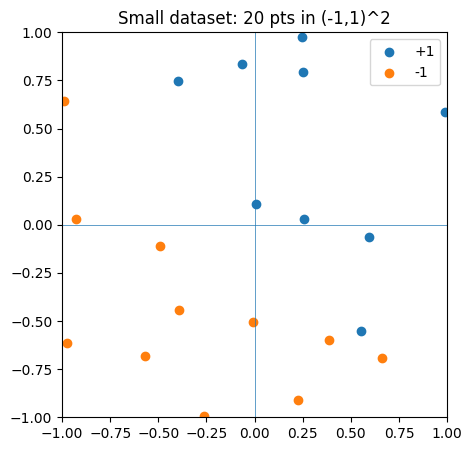

In [ ]:
# --- Build the small dataset ---
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)
n = 20
X_small = rng.uniform(-1.0, 1.0, size=(n, 2))
y_small = np.where(X_small[:, 0] + X_small[:, 1] >= 0.0, 1, -1)

def plot_data_small(X, y, w=None, title="Small dataset in (-1,1)^2"):
    """
    Minimal plotting helper.
    - If w is provided (shape (2,)), overlays the line w·x = 0 (through origin).
    """
    plt.figure(figsize=(5,5))
    plt.scatter(X[y==1,0],  X[y==1,1],  label="+1")
    plt.scatter(X[y==-1,0], X[y==-1,1], label="-1")
    plt.xlim(-1, 1); plt.ylim(-1, 1)
    plt.axhline(0, linewidth=0.5); plt.axvline(0, linewidth=0.5)

    if w is not None and np.any(np.abs(w) > 1e-12):
        # Plot boundary w1*x + w2*y = 0
        if abs(w[1]) > 1e-12:
            xs = np.linspace(-1, 1, 200)
            ys = -(w[0] / w[1]) * xs
            plt.plot(xs, ys, "--", label="your boundary")
        else:
            plt.plot([0, 0], [-1, 1], "--", label="your boundary")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.legend(); plt.title(title); plt.show()

# Visualize (no boundary yet)
plot_data_small(X_small, y_small, w=None, title="Small dataset: 20 pts in (-1,1)^2")


### 1A. Compute $R$, $\gamma$, and the bound

Use $w^*=[1,1]$ and $b^*=0$. For a **unit-norm** separator,
$$
\gamma \;=\; \min_i \; y_i \,\frac{w^*\cdot x_i + b^*}{\lVert w^* \rVert}
\;=\; \min_i \; \frac{|x_{1i}+x_{2i}|}{\sqrt{2}}.
$$

**Your tasks**
- Compute $R=\max_i \lVert x_i\rVert_2$.
- Compute $\gamma$ as above.
- Compute the bound $M \le \left(\frac{R}{\gamma}\right)^2$ and print all three values.


In [ ]:
# TODO: Part 1A — compute R, gamma, bound (write the lines yourself)
w_star = np.array([1,1])
R_small = np.max(np.linalg.norm(X_small,axis=1))
gamma_small = np.min(abs(X_small @ w_star)/ np.linalg.norm(w_star))
bound_small = (R_small/gamma_small)**2
print("R =", R_small); print("gamma =", gamma_small); print("Bound (R/gamma)^2 =", bound_small)


R = 1.1797459313653715
gamma = 0.0012627233390225655
Bound (R/gamma)^2 = 872892.0964405908


The perceptron mistake bound implies that, in the worst case, the algorithm could make up to 872892 mistakes because one of the points lies extremely close to the separating line (very small γ). In reality, the actual number of mistakes will be much smaller since we only have 20 points, but the bound shows how sensitive the perceptron is to points near the decision boundary.

### 1B. Train a **zero-offset** perceptron and count mistakes

Implement a perceptron with **bias fixed at 0**:
- Initialize $w=\mathbf{0}$.
- Choose a learning rate $ \eta $.
- Loop over the data for up to 100 epochs (stop early if no errors).
- **Mistakes = number of updates performed.** Count and report this number.
- Finally, plot your learned line with `plot_data_small(X_small, y_small, w=w)`.

**Deliverables:** $ \eta $, total mistakes, and the plot. Then, compare to your bound from **1A** in 2–4 sentences.


eta = 8.0 total mistakes = 16


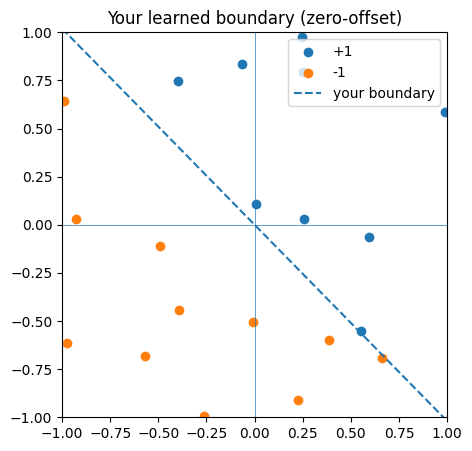

In [ ]:
# TODO: Part 1B — implement zero-offset perceptron training and count mistakes
w = np.zeros(2, dtype=float)
total_mistakes = 0
eta = 1.0  # try a few values
for epoch in range(100):
    errors = 0
    for i in range(len(X_small)):
        xi, yi = X_small[i], y_small[i]
        pred = np.sign(w @ xi)  # no bias
        if pred == 0:
            pred = 1
        if pred != yi:
          w= w+eta*yi*xi
          total_mistakes+=1
          errors+=1
    if errors == 0:
        break
print("eta =", eta, "total mistakes =", total_mistakes)
plot_data_small(X_small, y_small, w=w, title="Your learned boundary (zero-offset)")


With η = 1.0, the perceptron converged in 16 mistakes. This is much smaller than the theoretical bound (872,892). The huge gap is because γ was very close to zero, and a point was almost lying on the decision boundary. That makes the theoretical bound pessimistic, but the actual dataset is easy enough that the perceptron learns quickly.

## Part 2 — Validation on a larger dataset

**Goal.** Use a bigger dataset in $[0,10]^2$ with labels from the separator $x_1 + x_2 = 10$ to examine generalization.

In [ ]:
# Build the larger dataset
import numpy as np
np.random.seed(42)
num_samples = 100
X_big = np.random.rand(num_samples, 2) * 10.0
y_big = np.where(X_big[:, 0] + X_big[:, 1] > 10.0, 1, -1)

# Split 80/20
rng2 = np.random.default_rng(123)
perm = rng2.permutation(len(X_big))
split = int(0.8 * len(X_big))
idx_tr, idx_ho = perm[:split], perm[split:]
Xtr, ytr = X_big[idx_tr], y_big[idx_tr]
Xho, yho = X_big[idx_ho], y_big[idx_ho]


### 2A. Hold-out evaluation and same-distribution test

Train a perceptron on the train split and report:
- **Train accuracy** (on the train split),
- **Held-out accuracy** (on the 20% split),
- **New-data accuracy** on a fresh sample from the same distribution.

In [ ]:
# TODO: Part 2A — inline training loop + accuracies
w = np.zeros(2, dtype=float)
b = 0.0
eta = 1.0
for epoch in range(200):
    errors = 0
    for i in range(len(Xtr)):
        xi, yi = Xtr[i], ytr[i]
        yhat = 1 if (w @ xi) + b > 0 else -1
        if yhat != yi:
            w = w + eta * yi * xi
            b = b + eta * yi
            errors += 1
    if errors == 0:
        break
# Accuracies
preds_tr = np.where(Xtr @ w + b > 0, 1, -1)
preds_ho = np.where(Xho @ w + b > 0, 1, -1)
acc_tr = np.mean(preds_tr == ytr)
acc_ho = np.mean(preds_ho == yho)
Xnew = np.random.rand(200, 2) * 10.0
ynew = np.where(Xnew[:, 0] + Xnew[:, 1] > 10.0, 1, -1)
preds_new = np.where(Xnew @ w + b > 0, 1, -1)
acc_new = np.mean(preds_new == ynew)
print("Train acc:", acc_tr, "Held-out acc:", acc_ho, "New-data acc:", acc_new)


Train acc: 1.0 Held-out acc: 1.0 New-data acc: 1.0


The perceptron achieved perfect accuracy on the training set (1.0) which means it successfully learned a separating hyperplane. The held-out set also scored 1.0, showing that the model generalizes well to unseen points from the same distribution. The new-data accuracy is also 1.0, implying that the perceptron correctly classifies fresh samples. This is expected because the dataset is linearly separable and without the noise, allowing the perceptron to converge to an exact solution.

### 2B. Mistakes vs iterations (validation run)

Track **misclassifications per epoch** on all three sets during training and plot them:
- train mistakes (on the training split),
- held-out mistakes,
- new-data mistakes (use a **fixed** new-data sample for all epochs).

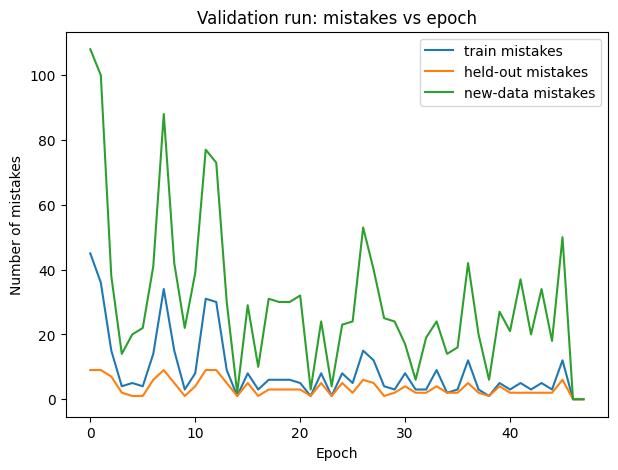

In [ ]:
#TODO: Part 2B — mistakes vs iterations plot
#Build a fixed new-data sample once
Xnew = np.random.rand(200, 2) * 10.0
ynew = np.where(Xnew[:, 0] + Xnew[:, 1] > 10.0, 1, -1)
train_mistakes, ho_mistakes, new_mistakes = [], [], []
# Re-initialize model
w = np.zeros(2, dtype=float)
b = 0.0
eta = 1.0
for epoch in range(200):
    errors = 0
    for i in range(len(Xtr)):
        xi, yi = Xtr[i], ytr[i]
        yhat = 1 if (w @ xi) + b > 0 else -1
        if yhat != yi:
            w = w + eta * yi * xi
            b = b + eta * yi
            errors += 1
    # Evaluate misclassifications (no updates here)
    preds_tr = np.where(Xtr @ w + b > 0, 1, -1)
    preds_ho = np.where(Xho @ w + b > 0, 1, -1)
    preds_new = np.where(Xnew @ w + b > 0, 1, -1)
    train_mistakes.append(int(np.sum(preds_tr != ytr)))
    ho_mistakes.append(int(np.sum(preds_ho != yho)))
    new_mistakes.append(int(np.sum(preds_new != ynew)))
    if errors == 0:
        break
import matplotlib.pyplot as plt
plt.figure(figsize=(7,5))
plt.plot(train_mistakes, label="train mistakes")
plt.plot(ho_mistakes, label="held-out mistakes")
plt.plot(new_mistakes, label="new-data mistakes")
plt.xlabel("Epoch"); plt.ylabel("Number of mistakes")
plt.title("Validation run: mistakes vs epoch")
plt.legend(); plt.show()


The held-out mistakes have smaller peaks and fewer errors at the beginning compared to the training set. The training mistakes curve is slightly spikier, while the new-data mistakes curve has the most errors initially. Over the epochs, all three curves steadily decrease and eventually converge to the same value. Overall, the trend shows that the perceptron makes fewer mistakes as training progresses, demonstrating learning and generalization.

## Part 3 — Explore on your own

Pick **one** idea and run a short experiment (include a plot or a metric and 3–6 sentences of discussion). Suggestions:
- Try two different $ \eta $ values and compare **total mistakes** (Part 1) or **convergence speed** (Part 2).
- Shuffle the data each epoch vs. fixed order: does it affect convergence?
- Add a tiny label-noise rate (e.g., 5%) to the large dataset and observe what changes.
- Use a different separating line (e.g., $2x_1 + x_2 = c$) and re-run the analysis.


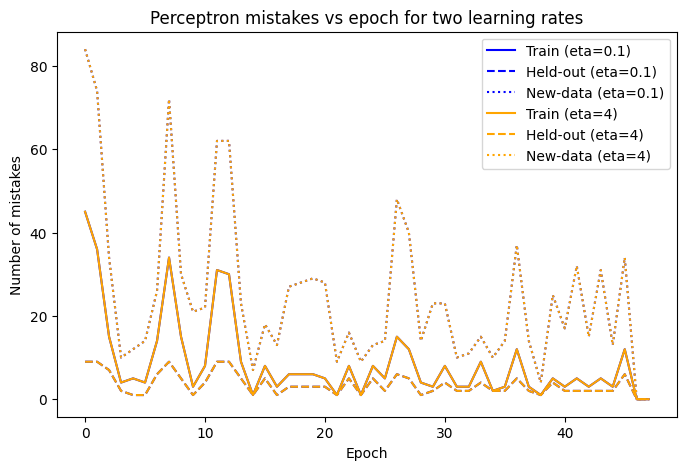

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Set up reproducibility and data
np.random.seed(42)
num_samples = 100
X_big = np.random.rand(num_samples, 2) * 10.0
y_big = np.where(X_big[:, 0] + X_big[:, 1] > 10.0, 1, -1)

# 80/20 split
rng2 = np.random.default_rng(123)
perm = rng2.permutation(len(X_big))
split = int(0.8 * len(X_big))
idx_tr, idx_ho = perm[:split], perm[split:]
Xtr, ytr = X_big[idx_tr], y_big[idx_tr]
Xho, yho = X_big[idx_ho], y_big[idx_ho]

# Fixed new-data sample for all epochs
Xnew = np.random.rand(200, 2) * 10.0
ynew = np.where(Xnew[:, 0] + Xnew[:, 1] > 10.0, 1, -1)

def perceptron_mistakes(Xtr, ytr, Xho, yho, Xnew, ynew, eta, max_epochs):
    w = np.zeros(2, dtype=float)
    b = 0.0
    train_mistakes, ho_mistakes, new_mistakes = [], [], []
    for epoch in range(max_epochs):
        errors = 0
        for i in range(len(Xtr)):
            xi, yi = Xtr[i], ytr[i]
            yhat = 1 if (w @ xi) + b > 0 else -1
            if yhat != yi:
                w = w + eta * yi * xi
                b = b + eta * yi
                errors += 1
        # Track mistakes
        preds_tr = np.where(Xtr @ w + b > 0, 1, -1)
        preds_ho = np.where(Xho @ w + b > 0, 1, -1)
        preds_new = np.where(Xnew @ w + b > 0, 1, -1)
        train_mistakes.append(int(np.sum(preds_tr != ytr)))
        ho_mistakes.append(int(np.sum(preds_ho != yho)))
        new_mistakes.append(int(np.sum(preds_new != ynew)))
        if errors == 0:
            break
    return train_mistakes, ho_mistakes, new_mistakes

# Run for both etas
train_01, ho_01, new_01 = perceptron_mistakes(Xtr, ytr, Xho, yho, Xnew, ynew, eta=0.1, max_epochs=200)
train_4, ho_4, new_4 = perceptron_mistakes(Xtr, ytr, Xho, yho, Xnew, ynew, eta=4, max_epochs=200)

# Plot for direct comparison
plt.figure(figsize=(8,5))
plt.plot(train_01, label="Train (eta=0.1)", color='blue')
plt.plot(ho_01, label="Held-out (eta=0.1)", color='blue', linestyle='--')
plt.plot(new_01, label="New-data (eta=0.1)", color='blue', linestyle=':')
plt.plot(train_4, label="Train (eta=4)", color='orange')
plt.plot(ho_4, label="Held-out (eta=4)", color='orange', linestyle='--')
plt.plot(new_4, label="New-data (eta=4)", color='orange', linestyle=':')
plt.xlabel("Epoch")
plt.ylabel("Number of mistakes")
plt.title("Perceptron mistakes vs epoch for two learning rates")
plt.legend()
plt.show()

I wanted to explore how the perceptron’s convergence speed changes with different learning rates, so I ran the same training loop for eta = 0.1 and eta = 4 on the larger dataset, tracking mistakes per epoch for training, held-out, and new-data sets. The plots for eta = 0.1 and eta = 4 appear identical because the dataset is linearly separable, and the perceptron converges extremely quickly for both learning rates. Once the decision boundary separates the points correctly, no further updates occur, so the number of mistakes per epoch remains the same. For this dataset, changing eta affects the size of the weight update but not the total number of updates or mistakes, since the algorithm reaches a correct separator in very few steps. In order to to make the difference between learning rates visible in mistakes vs epoch plot, we could introduce slight label noise or shuffle the data each epoch


## Rubric (100 pts total)

### Part 1 — Small dataset, mistake bound, zero‑offset perceptron (35 pts)
**1A. Radius, margin, bound (15 pts)**
- (4) Correct radius $R=\max_i \lVert x_i\rVert_2$
- (6) Correct margin $\gamma=\min_i \frac{|x_{1i}+x_{2i}|}{\sqrt{2}}$ (with $w^*=[1,1],\ b^*=0$ and unit‑norm)
- (3) Correct bound $(R/\gamma)^2$
- (2) Brief interpretation of what the bound implies

**1B. Zero‑offset perceptron + mistakes (20 pts)**
- (8) Correct implementation with **bias fixed at 0**; updates only on misclassified examples
- (4) Correct **total mistake (update) count** with sensible early stopping
- (4) Plot of learned boundary $w\cdot x=0$ over data
- (4) Comparison to the bound with a short explanation

---

### Part 2 — Validation on larger dataset (45 pts)
**2A. Hold‑out & same‑distribution test (25 pts)**
- (10) Correct inline perceptron training loop **with bias** and updates on mistakes
- (12) Accuracies reported: train (4), held‑out (4), new‑data (4)
- (3) Brief comments comparing the three accuracies

**2B. Mistakes vs. iterations plot (20 pts)**
- (4) Uses a **fixed** new‑data sample across epochs
- (9) Tracks per‑epoch misclassifications for train (3), held‑out (3), new‑data (3)
- (4) Clear, labeled plot (axes, legend, title)
- (3) 2–4 sentence interpretation of the curves

---

### Part 3 — Explore on your own (15 pts)
- (5) Clear question/idea and experimental setup
- (5) Execution quality (code/plot/metric)
- (5) Short discussion tying results to expectations

---

### Presentation (5 pts)
- (5) Organization, readable code, labeled figures, and concise markdown write‑ups
